In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
training_dir = './chest_xray/train'
validation_dir = './chest_xray/test'
test_dir = './chest_xray/val'

In [5]:
import numpy as np

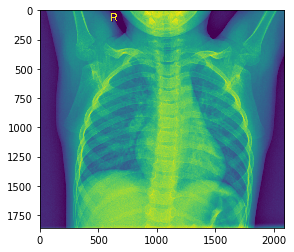

In [6]:
img = mpimg.imread(training_dir + '/NORMAL/IM-0115-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

In [7]:
def plot_images(path, labeled=False, max_images=6):
  amount = 0
  fig = plt.figure(figsize=(12, 6))

  for file in os.listdir(path):
    if file.endswith('.jpeg'):
      if amount == max_images:
        break

      img = mpimg.imread(os.path.join(path, file))
      plt.subplot(231+amount)
      if labeled:
        plt.title(file.split('_')[1])
      imgplot = plt.imshow(img)

      amount += 1

In [9]:
import os

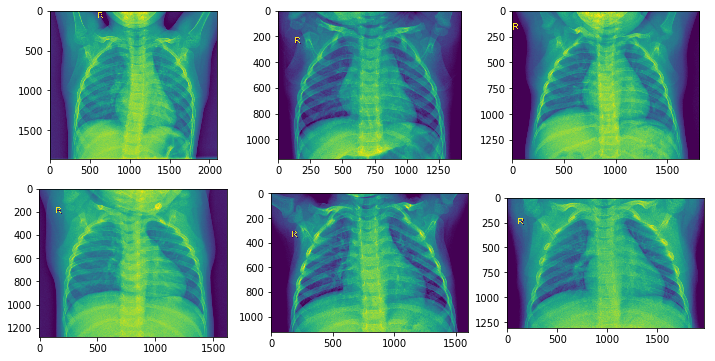

In [10]:
plot_images(training_dir + '/NORMAL')

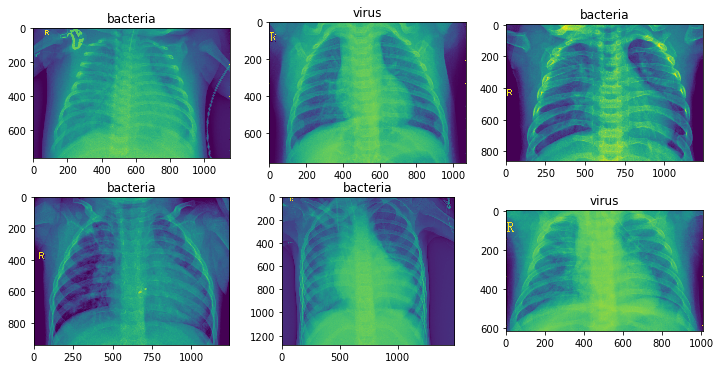

In [11]:
plot_images(training_dir + '/PNEUMONIA', labeled=True)

In [12]:
import keras

Using TensorFlow backend.


In [13]:
from keras.applications.inception_v3 import InceptionV3

In [14]:
from keras.preprocessing.image import ImageDataGenerator

In [15]:
rescale = 1./255.0
target_size = (150, 150)
batch_size = 32
class_mode = 'categorical'

train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=rescale
)
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [16]:

def get_model():
  base_model = InceptionV3(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  x = keras.layers.BatchNormalization()(x)
  predictions = keras.layers.Dense(2, activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = False
  
  model.summary()
  return model

In [17]:
model = get_model()



87916544/87910968 [==============================] - 92s 1us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
________________________

In [18]:
model.compile(keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)


Epoch 1/5
163/163 [==============================] - 490s 3s/step - loss: 0.3849 - accuracy: 0.8591 - val_loss: 0.8807 - val_accuracy: 0.6010
Epoch 2/5
163/163 [==============================] - 380s 2s/step - loss: 0.2745 - accuracy: 0.8886 - val_loss: 0.9428 - val_accuracy: 0.6859
Epoch 3/5
163/163 [==============================] - 385s 2s/step - loss: 0.2668 - accuracy: 0.8961 - val_loss: 2.6718 - val_accuracy: 0.6859
Epoch 4/5
163/163 [==============================] - 764s 5s/step - loss: 0.2362 - accuracy: 0.9043 - val_loss: 2.6244 - val_accuracy: 0.7212
Epoch 5/5
163/163 [==============================] - 377s 2s/step - loss: 0.2487 - accuracy: 0.9039 - val_loss: 0.9569 - val_accuracy: 0.7356


In [19]:
result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print('Loss:', result[0])
print('Accuracy:', result[1])

16/16 [==============================] - 2s 105ms/step
Loss: 6.575230598449707
Accuracy: 0.75


In [21]:
y_pred_batches = []
y_true_batches = []
y_img_batches = []


for i in range(0, len(test_generator)):
  y_img_batch, y_true_batch = test_generator[i]
  y_true_batch = y_true_batch.argmax(axis=-1)
  y_img_batches.append(y_img_batch)
  y_true_batches.append(y_true_batch)

  y_pred_batch = model.predict(y_img_batch)
  y_pred_batch = y_pred_batch.argmax(axis=-1)
  y_pred_batches.append(y_pred_batch)

y_pred_batches

[array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64)]

In [22]:
def predict_images(images_path, label):
  amount = 0
  fig = plt.figure(figsize=(18, 8))

  for file in os.listdir(images_path):
    if file.endswith('.jpeg'):
      if amount == 8:
        break

      img = mpimg.imread(os.path.join(images_path, file))
      plt.subplot(241+amount)
      plt.title('{} ---- {}'.format(label, 'NORMAL' if y_pred_batches[amount] == 0 else 'PNEUMONIA'))
      imgplot = plt.imshow(img)

      amount += 1

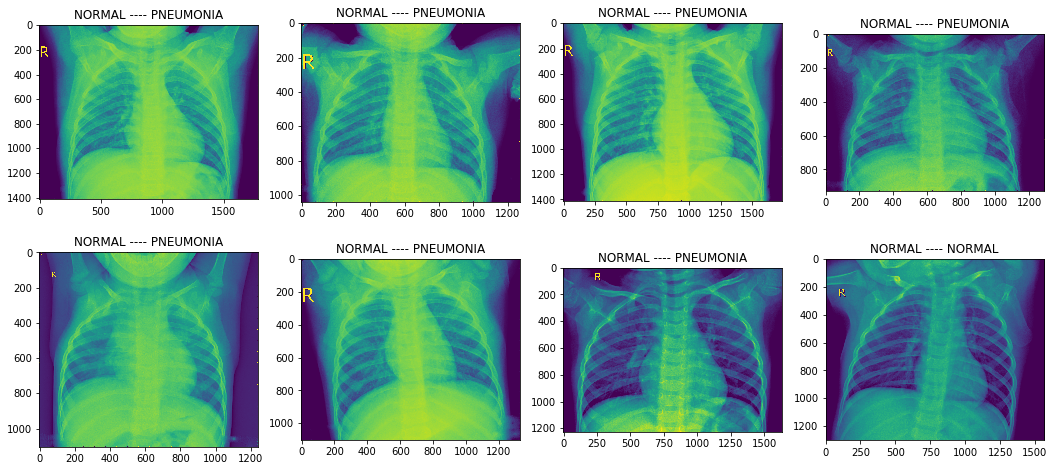

In [23]:
predict_images('./chest_xray/val/NORMAL', 'NORMAL')

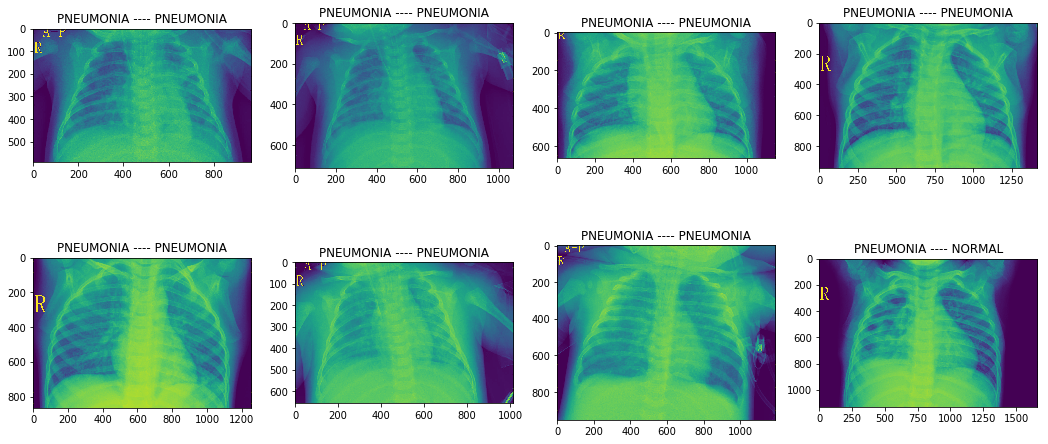

In [24]:
predict_images('./chest_xray/val/PNEUMONIA', 'PNEUMONIA')